In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
!pip install sklearn
from sklearn import svm
from sklearn.metrics import  accuracy_score

In [2]:
#--------------------------------Load Dataset Function--------------------------
#purposes:
  #(1): reads samples from the .csv dataset
  #(2): some discrte features have been stored in hot-one form so, 
    #they have been transformed into  associate number form
  #(3): split dataset into two halvs 60% for training 40% for testing  
  #outputs: x_train, y_train, x_test, y_test

def load_dataset(normalized = False):

  dataset = pd.read_csv("drive/MyDrive/retailMarketing.csv")
  N_samples = 1000

  #---------------------Normalization----------------
  if(normalized):
    AS_min = dataset.AmountSpent.min()
    AS_max = dataset.AmountSpent.max()
    dataset.AmountSpent = (dataset.AmountSpent - AS_min)/(AS_max - AS_min)
    sal_min = dataset.Salary.min();
    sal_max = dataset.Salary.max()
    dataset.Salary = (dataset.Salary - sal_min) / (sal_max - sal_min)
  #--------------------------------------------------

   #aux associate-table for mapping values of age(our target) to numbers
  ages = {"Young": 0, "Middle": 1, "Old": 2}

  prepared_dataset = np.zeros((1000,10)) #placeholder for 1000 samples each with 10 features

  ##Preapare samples--------------------------------------
  c = np.zeros((10,1))  #holds the current sample 
  for i in range(N_samples):
    c[0] = dataset.AmountSpent[i] 
    #catalogs_6 -> 0, catalogs_12 -> 1, catalogs_18 -> 2, catalogs_24 -> 3
    c[1] = np.argmax([dataset.Catalogs_6[i],dataset.Catalogs_12[i],dataset.Catalogs_18[i],dataset.Catalogs_24[i]])
    c[2] = dataset.Children[i]
    #Female -> 0, Male -> 1
    c[3] = np.argmax([dataset.Gender_Female[i],dataset.Gender_Male[i]])
    #Low -> 0, Medium -> 1, High -> 2
    c[4] = np.argmax([dataset.History_Low[i],dataset.History_Medium[i],dataset.History_High[i]])
    #Close -> 0, Far -> 1
    c[5] = np.argmax([dataset.Location_Close[i],dataset.Location_Far[i]])
    #Single -> 0, Married -> 1
    c[6] = np.argmax([dataset.Married_Single[i],dataset.Married_Married[i]])
    #Own -> 0, Rent -> 1
    c[7] = np.argmax([dataset.OwnHome_Own[i],dataset.OwnHome_Rent[i]])
    c[8] = dataset.Salary[i]
    #Young -> 0, Middle -> 1, Old -> 2
    c[9] = ages[dataset.Age[i]] #target!
    prepared_dataset[i,:] = c.reshape(1,10) #put the sample into dataset

  #----------------------------------------------------

  #-------------------shuffling------------------------
  np.random.shuffle(prepared_dataset)
  #----------------------------------------------------

  #-------------------splitting------------------------
  #60% for training, 40% for testing

  x_train = prepared_dataset[:600,:8]
  y_train = prepared_dataset[:600,9]

  x_test = prepared_dataset[600:1000,:8]
  y_test = prepared_dataset[600:1000,9]

  return x_train,y_train,x_test,y_test
  #-----------------------------------------------------
  
  #----------------------------END OF Load Dataset------------------------------


In [4]:
#---------------Implementing one vs one SVM multiclass classifier---------------
def ovo_prepare_dataset(x,y):
  #create an array of 6 lists as follows:
  #dataset[0],dataset[1] : x_train,y_train for young_middle
  #dataset[2],dataset[3] : x_train,y_train for young_old
  #dataset[4],dataset[5] : x_train_y_Train for middle_old
  #target: 0 -> young, 1 -> middle, 2 -> old
  dataset = [list() for i in range(6)] #array of 6 lists

  N_samples = x.shape[0]
  for i in range(N_samples):
    c = y[i]
    if(c == 0): #young
      dataset[0].append(x[i]) #young_middle
      dataset[1].append(c)
      dataset[2].append(x[i])#young_old
      dataset[3].append(c)
    elif(c == 1): #middle
      dataset[0].append(x[i]) #young_middle
      dataset[1].append(c)
      dataset[4].append(x[i]) #middle_old
      dataset[5].append(c)
    elif(c == 2): #old
      dataset[2].append(x[i])#young_old
      dataset[3].append(c)
      dataset[4].append(x[i])#middle_old
      dataset[5].append(c)

  return dataset

#-------------------------------------------------------------------------
def ovo_SVC(training_set,test_set):
  #young_middle
  y_pred_0 = svm.SVC(kernel = 'rbf').fit(training_set[0],training_set[1]).predict(test_set) 
  #young_old
  y_pred_1 = svm.SVC(kernel = 'rbf').fit(training_set[2],training_set[3]).predict(test_set)
  #middle_old
  y_pred_2 = svm.SVC(kernel = 'rbf').fit(training_set[4],training_set[5]).predict(test_set)
  return y_pred_0,y_pred_1,y_pred_2
#-------------------------------------------------------------------------
  
#----------------------Evaluating ovo SVC-------------------------
def eval_ovo_SVC(y_pred_0,y_pred_1,y_pred_2,y_test,N_test_samples):
  y_pred = np.zeros((N_test_samples,1))
  for i in range(N_test_samples):
      temp = np.zeros((3,1))
      temp[int(y_pred_0[i])] +=1
      temp[int(y_pred_1[i])] +=1
      temp[int(y_pred_2[i])] +=1
      y_pred[i] = np.argmax(temp)
  acc = accuracy_score(y_pred,y_test)
  return acc
 #-----------------------------------------------------------------

#-------------------------------------------------------------------------------

In [12]:
#-------------------------------PROBLEM #1--------------------------------------
x_train,y_train,x_test,y_test = load_dataset(normalized=False) 
#----------------RBF kernel---------------------------
t0 = time.clock()
y_pred = svm.SVC(kernel='rbf').fit(x_train,y_train).predict(x_test)
print("Kernel: RBF,C = 1.0 ->","Acc: ",accuracy_score(y_pred,y_test) * 100,"%")
t1 = time.clock() - t0
print("(( elapsed time for RBF kernel,without data normalization: ",t1,"))")

#-----------------------Polynomial kernel-------------
t0 = time.clock()
y_pred = svm.SVC(kernel='poly').fit(x_train,y_train).predict(x_test)
print("Kernel: Poly,C = 1.0,degree = 3 ->","Acc: ",accuracy_score(y_pred,y_test) * 100,"%")
t1 = time.clock() - t0
print("(( elapsed time for RBF kernel,without data normalization: ",t1,"))")
#-----------------------------------------------------

#-----------ovo SVM for multiclass classification-----
#implemented manually
x_train,y_train,x_test,y_test = load_dataset(False)
train_data = ovo_prepare_dataset(x_train,y_train)
preds = ovo_SVC(train_data,x_test)
acc = eval_ovo_SVC(*preds,y_test,400) * 100
print("\none vs one SVM Implemented using 3 distinct SVM\nAccuracy: ",acc,'%')
print('\n')

#-------------------------------------------------------------------------------


Kernel: RBF,C = 1.0 -> Acc:  60.75000000000001 %
(( elapsed time for RBF kernel,without data normalization:  0.02272799999999986 ))
Kernel: Poly,C = 1.0,degree = 3 -> Acc:  56.25 %
(( elapsed time for RBF kernel,without data normalization:  0.014479999999999826 ))

one vs one SVM Implemented using 3 distinct SVM
Accuracy:  67.0 %




In [ ]:
#-------------------------------PROBLEM #2--------------------------------------
t0 = time.clock()
y_pred = svm.SVC(C = 0.5,kernel='linear').fit(x_train,y_train).predict(x_test)
print("Kernel: Linear,C = 1.0 ->","Acc: ",accuracy_score(y_pred,y_test)*100,"%")
t1 = time.clock() - t0
print("(( elapsed time for Linear kernel,without data normalization: ",t1,"))")
#-------------------------------------------------------------------------------

Kernel: Linear,C = 1.0 -> Acc:  70.75 %
(( elapsed time for Linear kernel,without data normalization:  71.12173700000005 ))


In [ ]:
#-------------------------------PROBLEM #3--------------------------------------
x_train,y_train,x_test,y_test = load_dataset(normalized=True) 
#----------------RBF kernel---------------------------
t0 = time.clock()
y_pred = svm.SVC(kernel='rbf').fit(x_train,y_train).predict(x_test)
print("Kernel: RBF,C = 1.0 ->","Acc: ",accuracy_score(y_pred,y_test) * 100,"%")
t1 = time.clock() - t0
print("(( elapsed time for RBF kernel,with data normalization: ",t1,"))")

#-----------------------Polynomial kernel-------------
t0 = time.clock()
y_pred = svm.SVC(kernel='poly').fit(x_train,y_train).predict(x_test)
print("Kernel: Poly,C = 1.0,degree = 3 ->","Acc: ",accuracy_score(y_pred,y_test) * 100,"%")
t1 = time.clock() - t0
print("(( elapsed time for RBF kernel,with data normalization: ",t1,"))")
#-----------------------------------------------------

#-----------------------Linear kernel------------------
t0 = time.clock()
y_pred = svm.SVC(C = 1,kernel='linear').fit(x_train,y_train).predict(x_test)
print("Kernel: Linear,C = 1.0 ->","Acc: ",accuracy_score(y_pred,y_test)*100,"%")
t1 = time.clock() - t0
print("(( elapsed time for Linear kernel,with data normalization: ",t1,"))")
#-------------------------------------------------------

#-------------------------------------------------------------------------------


Kernel: RBF,C = 1.0 -> Acc:  66.0 %
(( elapsed time for RBF kernel,with data normalization:  0.02422999999998865 ))
Kernel: Poly,C = 1.0,degree = 3 -> Acc:  59.5 %
(( elapsed time for RBF kernel,with data normalization:  0.016143000000056418 ))
Kernel: Linear,C = 1.0 -> Acc:  71.25 %
(( elapsed time for Linear kernel,with data normalization:  0.013956999999891195 ))


In [16]:
#------------------------------PROBLEM #4---------------------------------------
x_train,y_train,x_test,y_test = load_dataset(normalized=True)
y_pred = svm.SVC(C = 1,kernel='rbf').fit(x_train,y_train).predict(x_test)
print("Kernel: RBF,C = 1.0,gamma = 0.001 ->","Acc: ",accuracy_score(y_pred,y_test)*100,"%")

y_pred = svm.SVC(C = 0.8,gamma = 0.01,kernel='rbf').fit(x_train,y_train).predict(x_test)
print("Kernel: RBF,C = 0.8,gamma = 0.01 ->","Acc: ",accuracy_score(y_pred,y_test) * 100,"%")

#parameters adjusted based on results of problem 5 (!)
y_pred = svm.SVC(C = 0.8,gamma = 0.09,kernel='rbf').fit(x_train,y_train).predict(x_test)
print("Kernel: RBF,C = 0.8,gamma = 0.09 ->","Acc: ",accuracy_score(y_pred,y_test) * 100,"%")

#parameters adjusted based on results of problem 5 (!)
y_pred = svm.SVC(C = 4.849999999999991,gamma = 0.2,kernel='rbf').fit(x_train,y_train).predict(x_test)
print("Kernel: RBF,C = 4.849999999999991,gamma = 0.05 ->","Acc: ",accuracy_score(y_pred,y_test) * 100,"%")

y_pred = svm.SVC(C = 0.7,gamma = 0.00002,kernel='rbf').fit(x_train,y_train).predict(x_test)
print("Kernel: RBF,C = 4.1,gamma = 0.1 ->","Acc: ",accuracy_score(y_pred,y_test) * 100,"%")
#-------------------------------------------------------------------------------

Kernel: RBF,C = 1.0,gamma = 0.001 -> Acc:  62.74999999999999 %
Kernel: RBF,C = 0.8,gamma = 0.01 -> Acc:  49.0 %
Kernel: RBF,C = 0.8,gamma = 0.09 -> Acc:  64.5 %
Kernel: RBF,C = 4.849999999999991,gamma = 0.05 -> Acc:  67.25 %
Kernel: RBF,C = 4.1,gamma = 0.1 -> Acc:  48.75 %


In [ ]:
best_c

2.549999999999999

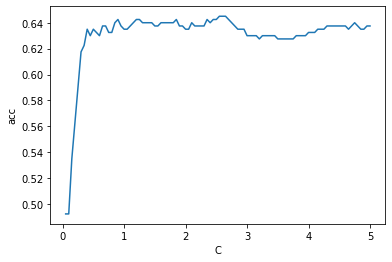

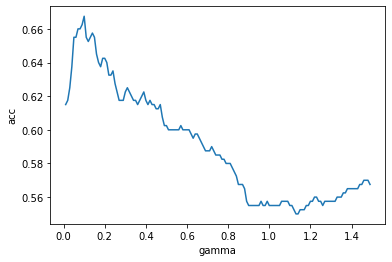

In [ ]:
#-----------------------------PROBLEM #5 ---------------------------------------
x_vals = list()
y_vals = list()
c = 0.05
step = 0.05
while(c <= 5):
  y_pred = svm.SVC(C = c,kernel = 'rbf').fit(x_train,y_train).predict(x_test)
  acc = accuracy_score(y_test,y_pred)
  x_vals.append(c)
  y_vals.append(acc)
  c += step
plt.plot(x_vals,y_vals)
plt.xlabel("C")
plt.ylabel("acc")
plt.show()

c_i = np.argmax(np.array(y_vals))
best_c = x_vals[c_i]
g = 0.01
step = 0.01
x_vals.clear()
y_vals.clear()
while(g <= 1.5):
  y_pred = svm.SVC(C = best_c,kernel = 'rbf',gamma = g).fit(x_train,y_train).predict(x_test)
  acc = accuracy_score(y_test,y_pred)
  x_vals.append(g)
  y_vals.append(acc)
  g += step

plt.plot(x_vals,y_vals)
plt.xlabel("gamma")
plt.ylabel("acc")
plt.show()
#-------------------------------------------------------------------------------

In [ ]:
y_pred = svm.SVC(C = 4.85,gamma = 0.15,kernel='rbf').fit(x_train,y_train).predict(x_test)
print("Kernel: RBF,C = 1.0 ->","Acc: ",accuracy_score(y_pred,y_test) * 100,"%")

Kernel: RBF,C = 1.0 -> Acc:  69.0 %


In [ ]:
x_vals[np.argmax(y_vals)]

0.09999999999999999